In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.feature_selection import RFECV

In [2]:
dfs = [pd.read_parquet('../Outputs/cleaned-5-player-features-camera-rounds.parquet'),
       pd.read_parquet('../Outputs/cleaned-5-player-features-3d-rounds.parquet'),
       pd.read_parquet('../Outputs/cleaned-5-player-features-camera-halves.parquet'),
       pd.read_parquet('../Outputs/cleaned-5-player-features-3d-halves.parquet')
       ]

In [3]:
# Add column for the number of seconds players are alive to rounds dfs
for i in range(5):
    dfs[0][f'p{i+1}_time_alive'] = (dfs[0][f'p{i+1}_num_samples_d'] + dfs[0][f'p{i+1}_num_samples_j']) / 2
    dfs[1][f'p{i+1}_time_alive'] = (dfs[1][f'p{i+1}_num_samples_d'] + dfs[1][f'p{i+1}_num_samples_j']) / 2

In [4]:
for df in dfs:
    print(df.head())

                                matchID     mapName side  roundNum  p1_name  \
0  035bfeb7-396b-4c48-b2aa-5f002c44b7c2  de_inferno   CT         1  Plopski   
1  035bfeb7-396b-4c48-b2aa-5f002c44b7c2  de_inferno   CT         4  Plopski   
2  035bfeb7-396b-4c48-b2aa-5f002c44b7c2  de_inferno   CT         5  Plopski   
3  035bfeb7-396b-4c48-b2aa-5f002c44b7c2  de_inferno   CT         7  Plopski   
4  035bfeb7-396b-4c48-b2aa-5f002c44b7c2  de_inferno   CT         8  Plopski   

  p2_name p3_name p4_name p5_name   p1_ch_area  ...  p5_alpha_d  \
0     REZ  es3tag  hampus    phzy  1145.626984  ...    0.366504   
1     REZ  es3tag  hampus    phzy  1299.840957  ...    0.109935   
2     REZ  es3tag  hampus    phzy  1412.352284  ...    0.047636   
3     REZ  es3tag  hampus    phzy  1157.643736  ...    1.000012   
4     REZ  es3tag  hampus    phzy   735.447172  ...    0.057844   

   p5_num_samples_d  p5_num_samples_j    p5_alpha_j          Label  \
0              36.0             184.0  2.571728e-01 

In [5]:
half_metrics = [
    'ch_area', 'ch_volume', 'ch_area_normed', 'ch_volume_normed',
    'frac_dim',
    'C1', 'C2', 'C3', 'C4', 'C5',
    'alpha_d', 'alpha_j', 'num_samples_d','num_samples_j',
]

round_metrics = half_metrics + ['time_alive']

# Statistic suffixes
stats = ['min', 'max', 'mean',  'std']

aggregate_dfs = []
for i in range(len(dfs)):
       if i <= 1:
              metrics = round_metrics
              # List comprehension for output column names
              output_columns = [f"{metric}_{stat}" for metric in metrics for stat in stats]

              # Iterate through each metric and calculate row-wise stats
              for metric in metrics:
                     cols = [f'p{i+1}_{metric}' for i in range(5)]

                     # Convert to a 2D array for row-wise operation
                     data = dfs[i][cols].to_numpy()

                     # Add new columns with row-wise aggregations
                     dfs[i][f'{metric}_min'] = np.min(data, axis=1)
                     dfs[i][f'{metric}_max'] = np.max(data, axis=1)
                     dfs[i][f'{metric}_mean'] = np.mean(data, axis=1)
                     dfs[i][f'{metric}_std'] = np.std(data, axis=1)
              aggregate_dfs.append(dfs[i][['matchID', 'mapName', 'side', 'roundNum', 'Label'] + output_columns])
       else:
              metrics = half_metrics
              # List comprehension for output column names
              output_columns = [f"{metric}_{stat}" for metric in metrics for stat in stats]

              # Iterate through each metric and calculate row-wise stats
              for metric in metrics:
                     cols = [f'p{i+1}_{metric}' for i in range(5)]

                     # Convert to a 2D array for row-wise operation
                     data = dfs[i][cols].to_numpy()

                     # Add new columns with row-wise aggregations
                     dfs[i][f'{metric}_min'] = np.min(data, axis=1)
                     dfs[i][f'{metric}_max'] = np.max(data, axis=1)
                     dfs[i][f'{metric}_mean'] = np.mean(data, axis=1)
                     dfs[i][f'{metric}_std'] = np.std(data, axis=1)
              aggregate_dfs.append(dfs[i][['matchID', 'mapName', 'side', 'team', 'Label'] + output_columns])

In [6]:
# Drop any rounds where a player was alive for less than 30 seconds in the rounds dfs
aggregate_dfs[0] = aggregate_dfs[0].loc[aggregate_dfs[0].time_alive_min >= 30]
aggregate_dfs[1] = aggregate_dfs[1].loc[aggregate_dfs[1].time_alive_min >= 30]

# Create the merged 3D and Camera Halves df as well
aggregate_dfs.append(pd.merge(aggregate_dfs[3], aggregate_dfs[2], on=['matchID', 'mapName', 'side', 'team', 'Label'], suffixes=('_3d', '_cam')))
aggregate_dfs.append(pd.merge(aggregate_dfs[1], aggregate_dfs[0], on=['matchID', 'mapName', 'side', 'roundNum', 'Label'], suffixes=('_3d', '_cam')))

In [7]:
# Make a dict
dfs_dict  = {'Camera Rounds': aggregate_dfs[0], 'Movement Rounds': aggregate_dfs[1], 'Camera Halves': aggregate_dfs[2], 'Movement Halves': aggregate_dfs[3], 'Movement & Camera Halves': aggregate_dfs[4], 'Movement & Camera Rounds': aggregate_dfs[5]}

In [8]:
# Dictionary of feature sets for various ablation studies
feature_sets = {
    "All": [
        'ch_area_min', 'ch_area_max', 'ch_area_mean', 'ch_area_std',
        'ch_volume_min', 'ch_volume_max', 'ch_volume_mean', 'ch_volume_std',
        'ch_area_normed_min', 'ch_area_normed_max', 'ch_area_normed_mean',
        'ch_area_normed_std', 'ch_volume_normed_min', 'ch_volume_normed_max',
        'ch_volume_normed_mean', 'ch_volume_normed_std', 'frac_dim_min',
        'frac_dim_max', 'frac_dim_mean', 'frac_dim_std', 'C1_min', 'C1_max',
        'C1_mean', 'C1_std', 'C2_min', 'C2_max', 'C2_mean', 'C2_std', 'C3_min',
        'C3_max', 'C3_mean', 'C3_std', 'C4_min', 'C4_max', 'C4_mean', 'C4_std',
        'C5_min', 'C5_max', 'C5_mean', 'C5_std', 'alpha_d_min', 'alpha_d_max',
        'alpha_d_mean', 'alpha_d_std', 'alpha_j_min', 'alpha_j_max',
        'alpha_j_mean', 'alpha_j_std'
    ],
    #
    # "No regular convex hull features": [
    #     'ch_area_normed_min', 'ch_area_normed_max', 'ch_area_normed_mean',
    #     'ch_area_normed_std', 'ch_volume_normed_min', 'ch_volume_normed_max',
    #     'ch_volume_normed_mean', 'ch_volume_normed_std', 'frac_dim_min',
    #     'frac_dim_max', 'frac_dim_mean', 'frac_dim_std', 'C1_min', 'C1_max',
    #     'C1_mean', 'C1_std', 'C2_min', 'C2_max', 'C2_mean', 'C2_std', 'C3_min',
    #     'C3_max', 'C3_mean', 'C3_std', 'C4_min', 'C4_max', 'C4_mean', 'C4_std',
    #     'C5_min', 'C5_max', 'C5_mean', 'C5_std', 'alpha_d_min', 'alpha_d_max',
    #     'alpha_d_mean', 'alpha_d_std', 'alpha_j_min', 'alpha_j_max',
    #     'alpha_j_mean', 'alpha_j_std'
    # ],
    # "Only regular convex hull features": [
    #     'ch_area_min', 'ch_area_max', 'ch_area_mean', 'ch_area_std',
    #     'ch_volume_min', 'ch_volume_max', 'ch_volume_mean', 'ch_volume_std'
    # ],
    #
    # "No convex hull features at all": [
    #     'frac_dim_min', 'frac_dim_max', 'frac_dim_mean', 'frac_dim_std',
    #     'C1_min', 'C1_max', 'C1_mean', 'C1_std', 'C2_min', 'C2_max', 'C2_mean', 'C2_std',
    #     'C3_min', 'C3_max', 'C3_mean', 'C3_std', 'C4_min', 'C4_max', 'C4_mean', 'C4_std',
    #     'C5_min', 'C5_max', 'C5_mean', 'C5_std', 'alpha_d_min', 'alpha_d_max',
    #     'alpha_d_mean', 'alpha_d_std', 'alpha_j_min', 'alpha_j_max', 'alpha_j_mean', 'alpha_j_std'
    # ],
    # "Only convex hull features": [
    #     'ch_area_min', 'ch_area_max', 'ch_area_mean', 'ch_area_std',
    #     'ch_volume_min', 'ch_volume_max', 'ch_volume_mean', 'ch_volume_std',
    #     'ch_area_normed_min', 'ch_area_normed_max', 'ch_area_normed_mean',
    #     'ch_area_normed_std', 'ch_volume_normed_min', 'ch_volume_normed_max',
    #     'ch_volume_normed_mean', 'ch_volume_normed_std'
    # ],
    #
    # "No normalized convex hull features": [
    #     'ch_area_min', 'ch_area_max', 'ch_area_mean', 'ch_area_std',
    #     'ch_volume_min', 'ch_volume_max', 'ch_volume_mean', 'ch_volume_std',
    #     'frac_dim_min', 'frac_dim_max', 'frac_dim_mean', 'frac_dim_std',
    #     'C1_min', 'C1_max', 'C1_mean', 'C1_std', 'C2_min', 'C2_max', 'C2_mean', 'C2_std',
    #     'C3_min', 'C3_max', 'C3_mean', 'C3_std', 'C4_min', 'C4_max', 'C4_mean', 'C4_std',
    #     'C5_min', 'C5_max', 'C5_mean', 'C5_std', 'alpha_d_min', 'alpha_d_max',
    #     'alpha_d_mean', 'alpha_d_std', 'alpha_j_min', 'alpha_j_max', 'alpha_j_mean', 'alpha_j_std'
    # ],
    # "Only normalized convex hull features": [
    #     'ch_area_normed_min', 'ch_area_normed_max', 'ch_area_normed_mean',
    #     'ch_area_normed_std', 'ch_volume_normed_min', 'ch_volume_normed_max',
    #     'ch_volume_normed_mean', 'ch_volume_normed_std'
    # ],
    #
    # "No entropy constant features": [
    #     'ch_area_min', 'ch_area_max', 'ch_area_mean', 'ch_area_std',
    #     'ch_volume_min', 'ch_volume_max', 'ch_volume_mean', 'ch_volume_std',
    #     'ch_area_normed_min', 'ch_area_normed_max', 'ch_area_normed_mean',
    #     'ch_area_normed_std', 'ch_volume_normed_min', 'ch_volume_normed_max',
    #     'ch_volume_normed_mean', 'ch_volume_normed_std', 'frac_dim_min',
    #     'frac_dim_max', 'frac_dim_mean', 'frac_dim_std',
    #     'alpha_d_min', 'alpha_d_max', 'alpha_d_mean', 'alpha_d_std',
    #     'alpha_j_min', 'alpha_j_max', 'alpha_j_mean', 'alpha_j_std'
    # ],
    # "Only entropy constant features": [
    #     'C1_min', 'C1_max', 'C1_mean', 'C1_std', 'C2_min', 'C2_max', 'C2_mean', 'C2_std',
    #     'C3_min', 'C3_max', 'C3_mean', 'C3_std', 'C4_min', 'C4_max', 'C4_mean', 'C4_std',
    #     'C5_min', 'C5_max', 'C5_mean', 'C5_std'
    # ],
    #
    # "No fractal dimension features": [
    #     'ch_area_min', 'ch_area_max', 'ch_area_mean', 'ch_area_std',
    #     'ch_volume_min', 'ch_volume_max', 'ch_volume_mean', 'ch_volume_std',
    #     'ch_area_normed_min', 'ch_area_normed_max', 'ch_area_normed_mean',
    #     'ch_area_normed_std', 'ch_volume_normed_min', 'ch_volume_normed_max',
    #     'ch_volume_normed_mean', 'ch_volume_normed_std', 'C1_min', 'C1_max',
    #     'C1_mean', 'C1_std', 'C2_min', 'C2_max', 'C2_mean', 'C2_std', 'C3_min',
    #     'C3_max', 'C3_mean', 'C3_std', 'C4_min', 'C4_max', 'C4_mean', 'C4_std',
    #     'C5_min', 'C5_max', 'C5_mean', 'C5_std', 'alpha_d_min', 'alpha_d_max',
    #     'alpha_d_mean', 'alpha_d_std', 'alpha_j_min', 'alpha_j_max',
    #     'alpha_j_mean', 'alpha_j_std'
    # ],
    # "Only fractal dimension features": [
    #     'frac_dim_min', 'frac_dim_max', 'frac_dim_mean', 'frac_dim_std'
    # ],
    #
    # "No alpha features": [
    #     'ch_area_min', 'ch_area_max', 'ch_area_mean', 'ch_area_std',
    #     'ch_volume_min', 'ch_volume_max', 'ch_volume_mean', 'ch_volume_std',
    #     'ch_area_normed_min', 'ch_area_normed_max', 'ch_area_normed_mean',
    #     'ch_area_normed_std', 'ch_volume_normed_min', 'ch_volume_normed_max',
    #     'ch_volume_normed_mean', 'ch_volume_normed_std', 'frac_dim_min',
    #     'frac_dim_max', 'frac_dim_mean', 'frac_dim_std', 'C1_min', 'C1_max',
    #     'C1_mean', 'C1_std', 'C2_min', 'C2_max', 'C2_mean', 'C2_std', 'C3_min',
    #     'C3_max', 'C3_mean', 'C3_std', 'C4_min', 'C4_max', 'C4_mean', 'C4_std',
    #     'C5_min', 'C5_max', 'C5_mean', 'C5_std'
    # ],
    # "Only alpha features": [
    #     'alpha_d_min', 'alpha_d_max', 'alpha_d_mean', 'alpha_d_std',
    #     'alpha_j_min', 'alpha_j_max', 'alpha_j_mean', 'alpha_j_std'
    # ]
}

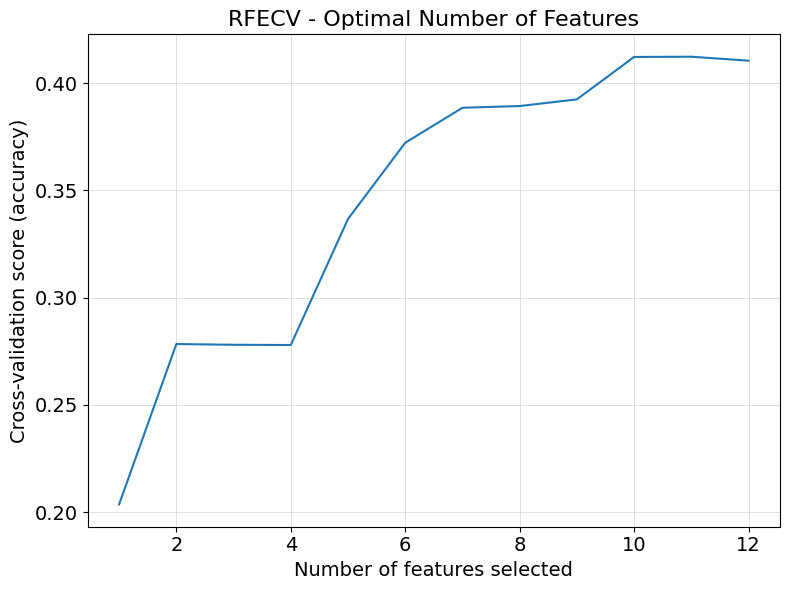


=== Camera Rounds - Feature Set: All ===
Feature count: 12


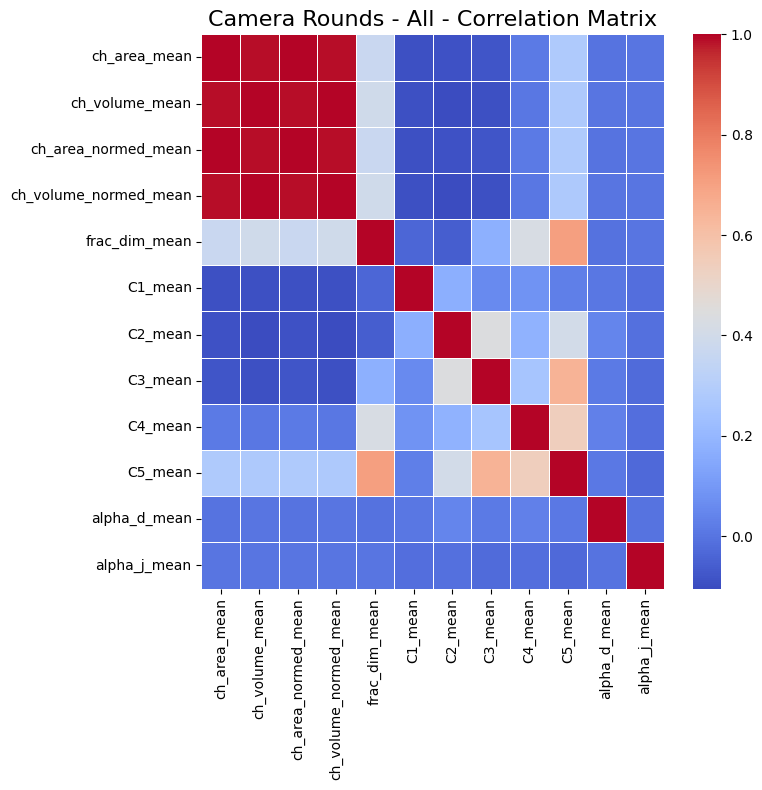

Train Accuracy: 0.4192
Test Accuracy: 0.4257 | Precision: 0.4410 | Recall: 0.4257 | F1: 0.4214


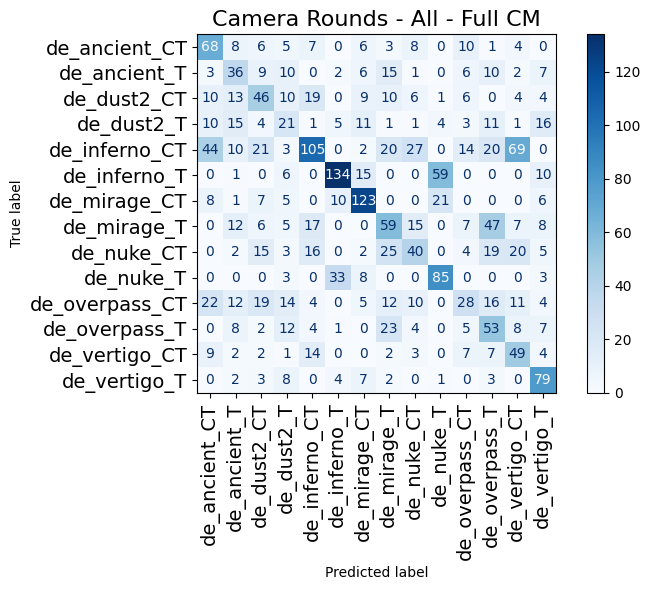

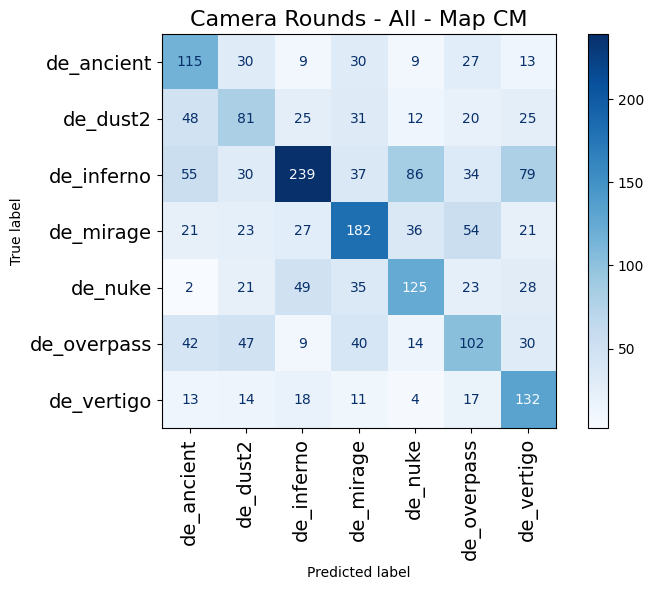

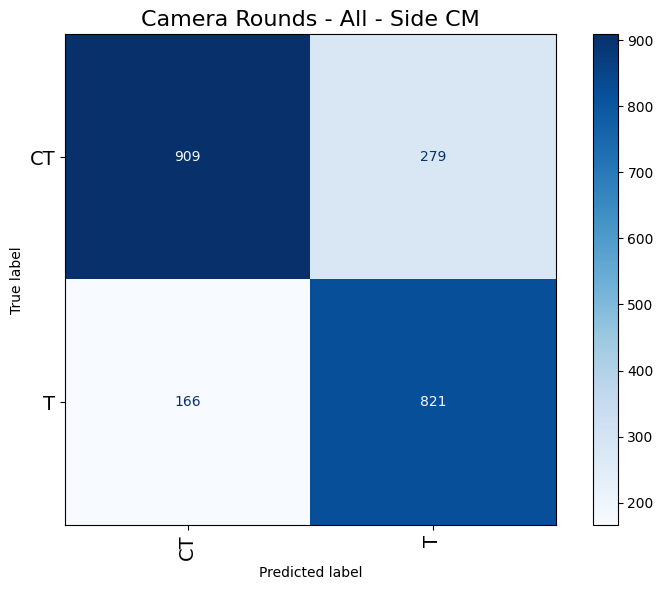

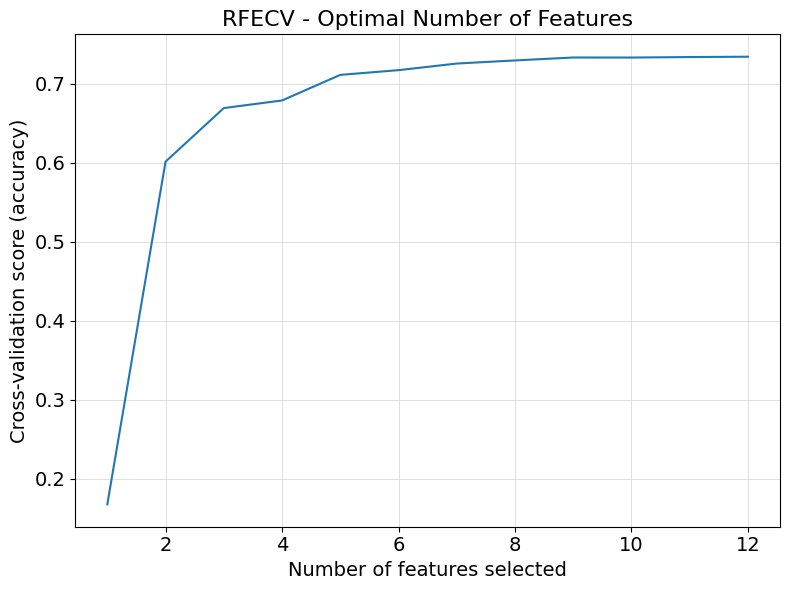


=== Movement Rounds - Feature Set: All ===
Feature count: 12


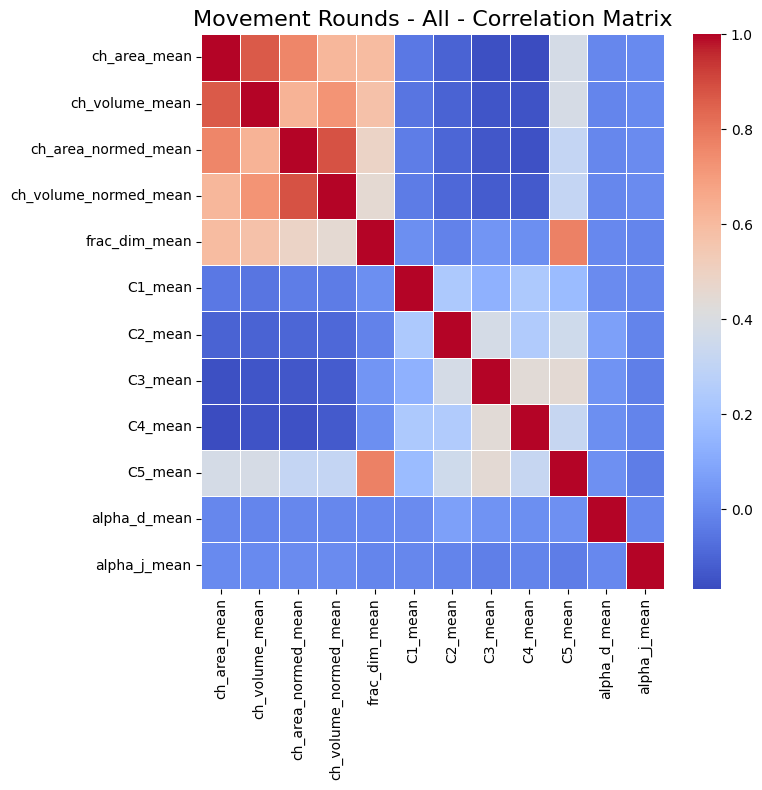

Train Accuracy: 0.7420
Test Accuracy: 0.7393 | Precision: 0.7460 | Recall: 0.7393 | F1: 0.7394


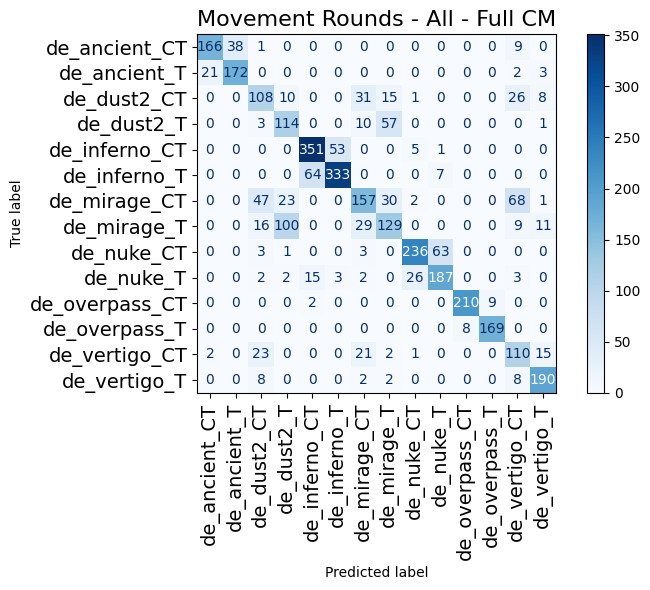

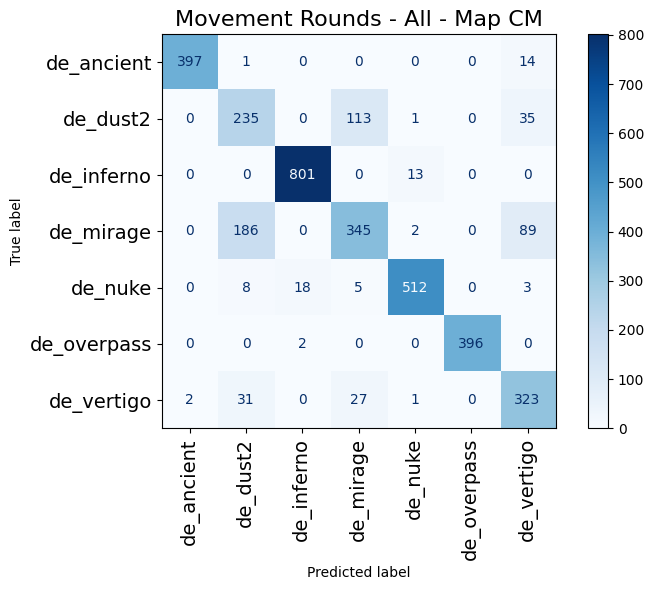

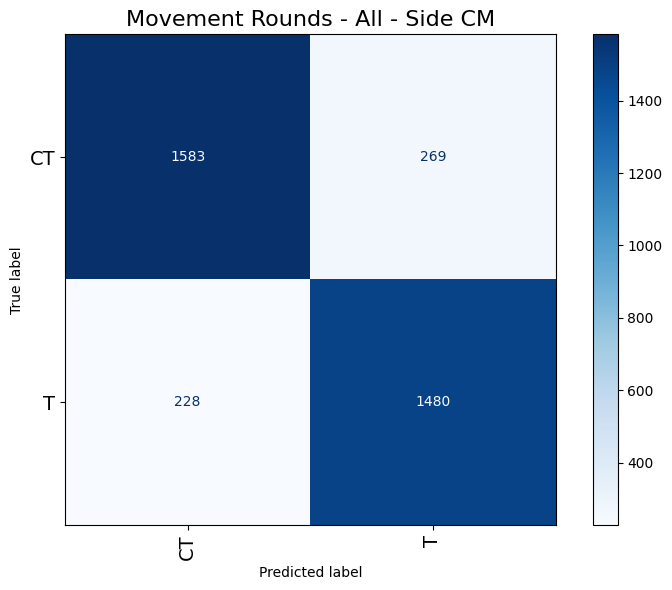

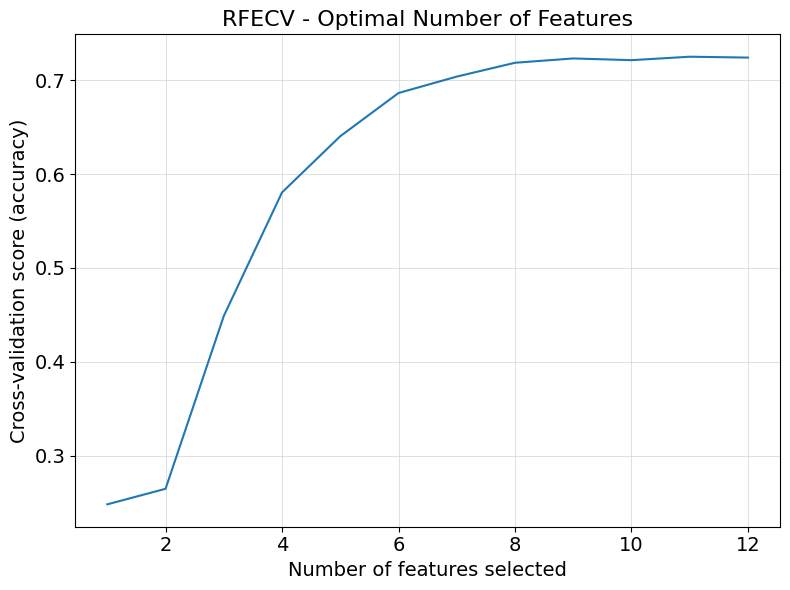


=== Camera Halves - Feature Set: All ===
Feature count: 12


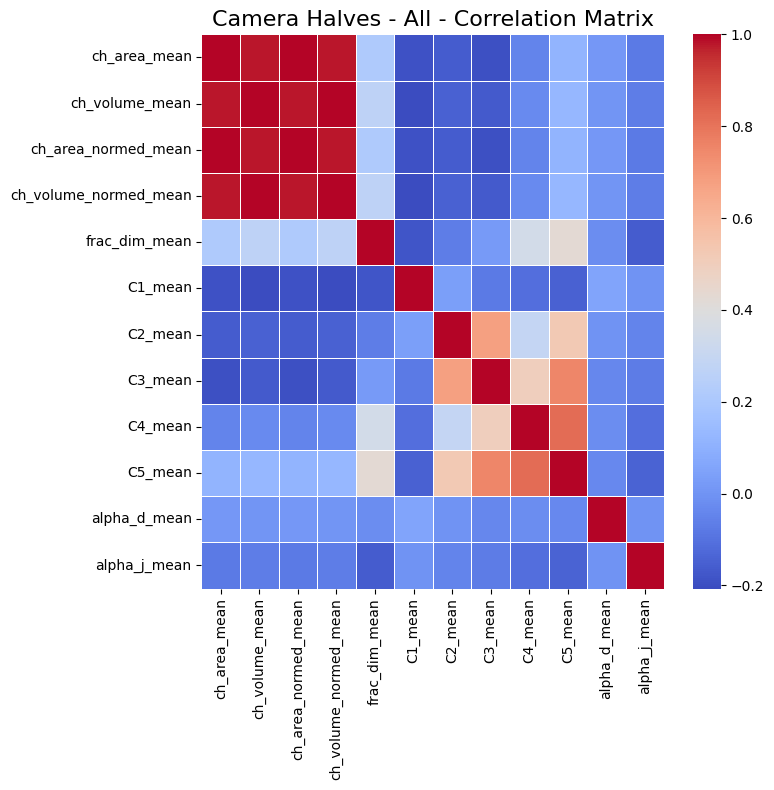

Train Accuracy: 0.7668
Test Accuracy: 0.6875 | Precision: 0.6938 | Recall: 0.6875 | F1: 0.6837


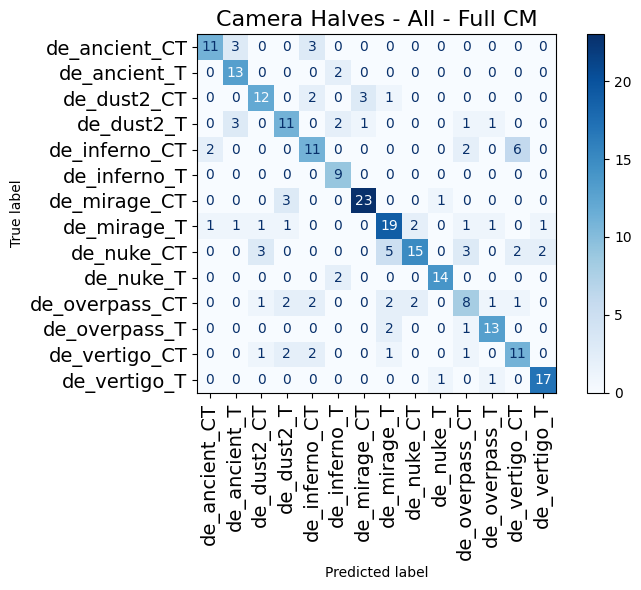

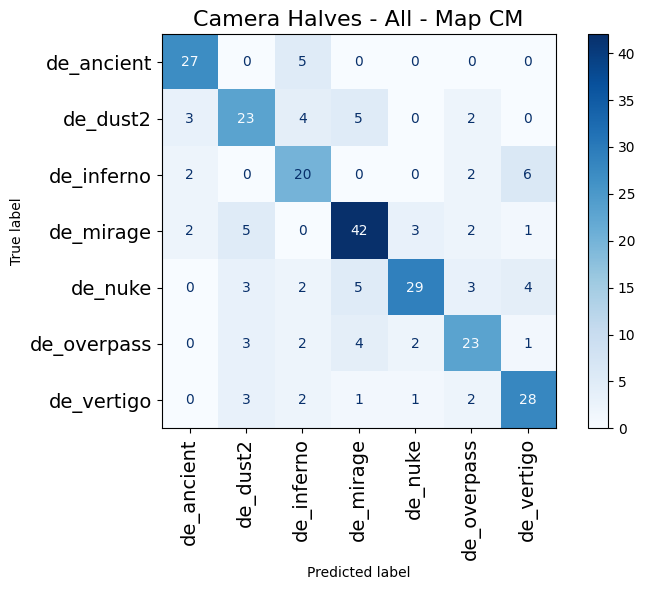

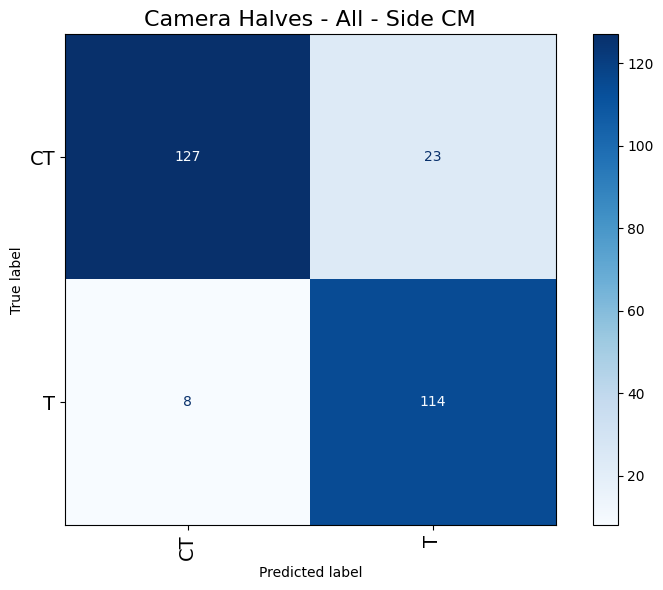

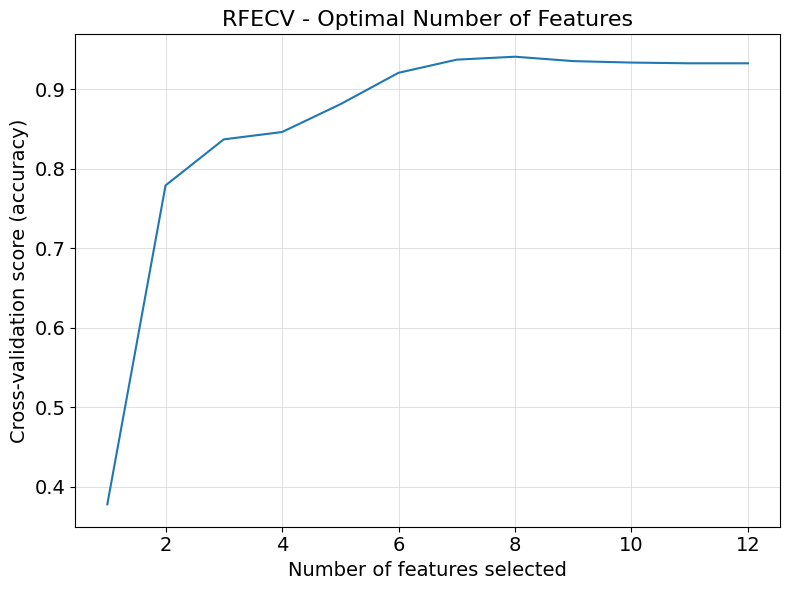


=== Movement Halves - Feature Set: All ===
Feature count: 12


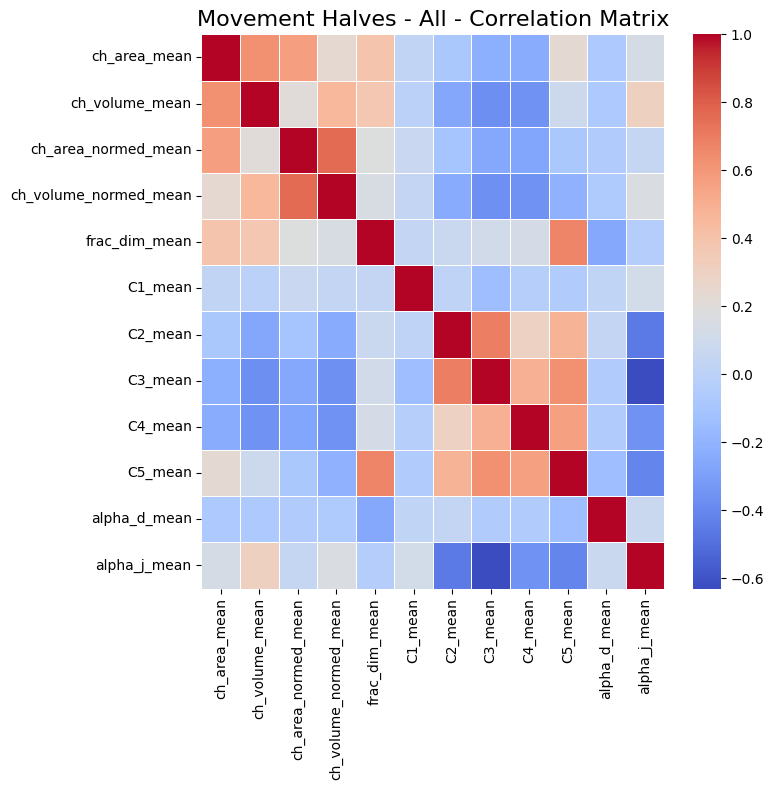

Train Accuracy: 0.9558
Test Accuracy: 0.9338 | Precision: 0.9343 | Recall: 0.9338 | F1: 0.9337


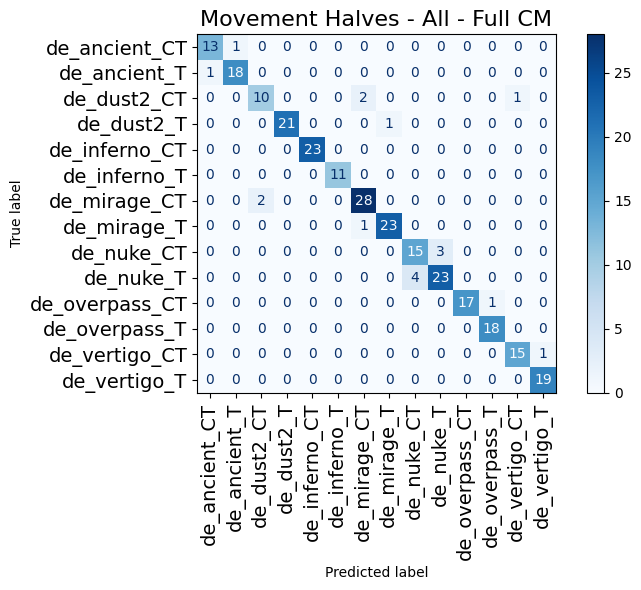

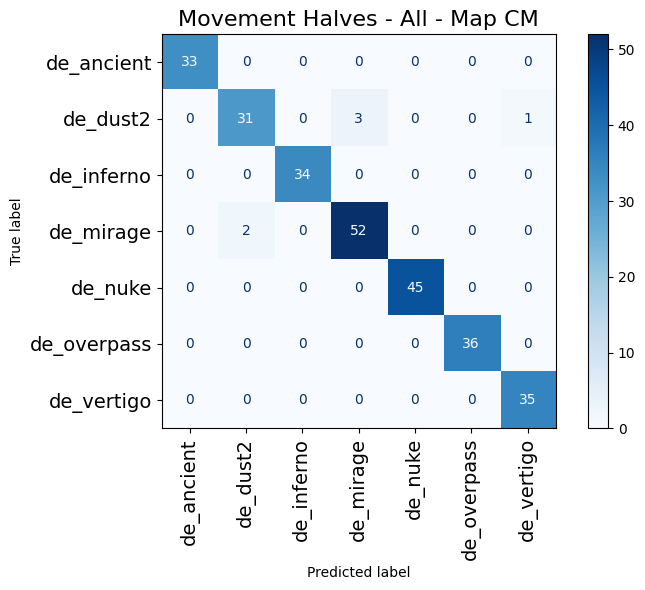

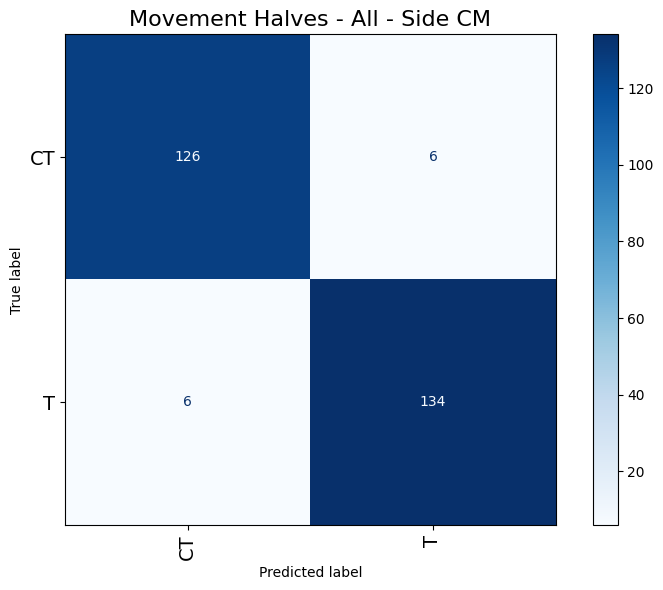

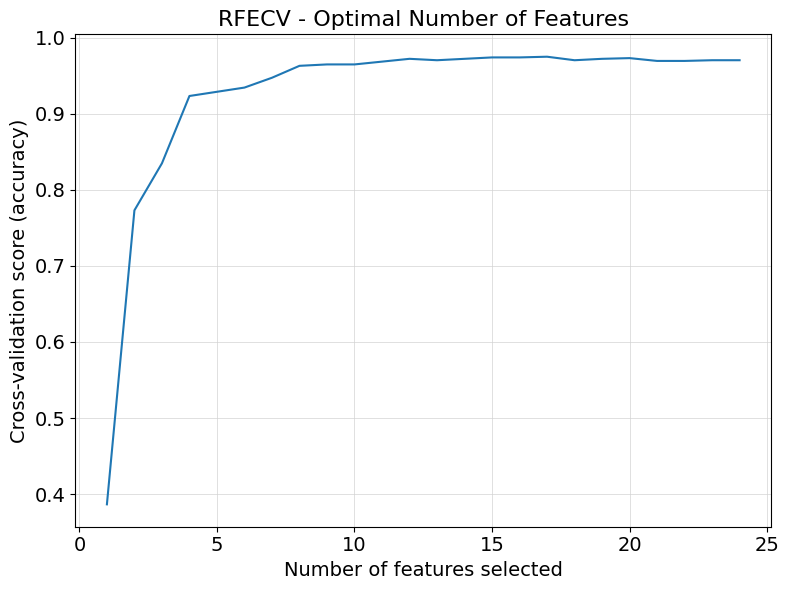


=== Movement & Camera Halves - Feature Set: All ===
Feature count: 24


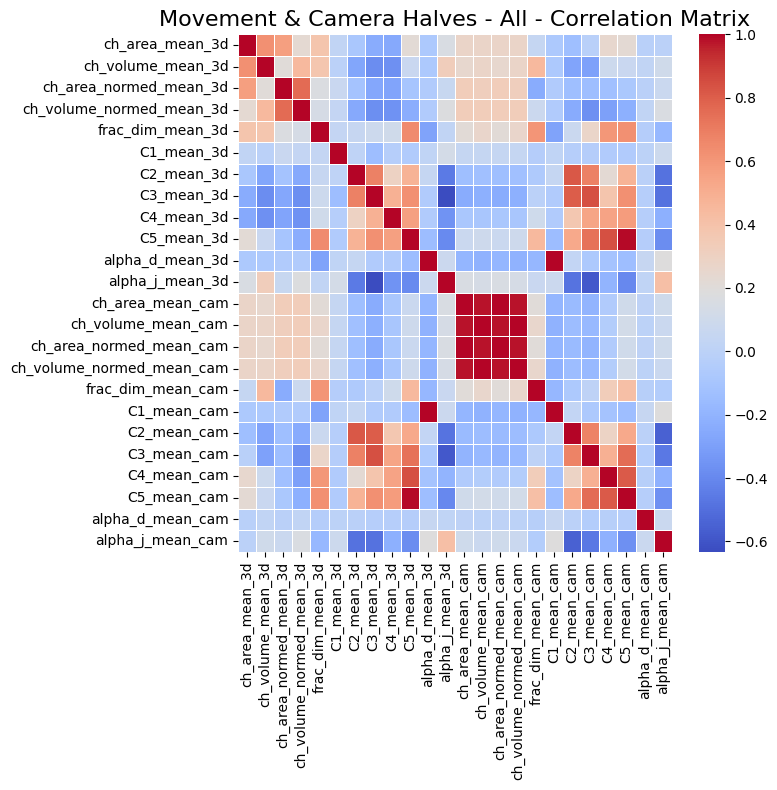

Train Accuracy: 0.9935
Test Accuracy: 0.9743 | Precision: 0.9791 | Recall: 0.9743 | F1: 0.9752


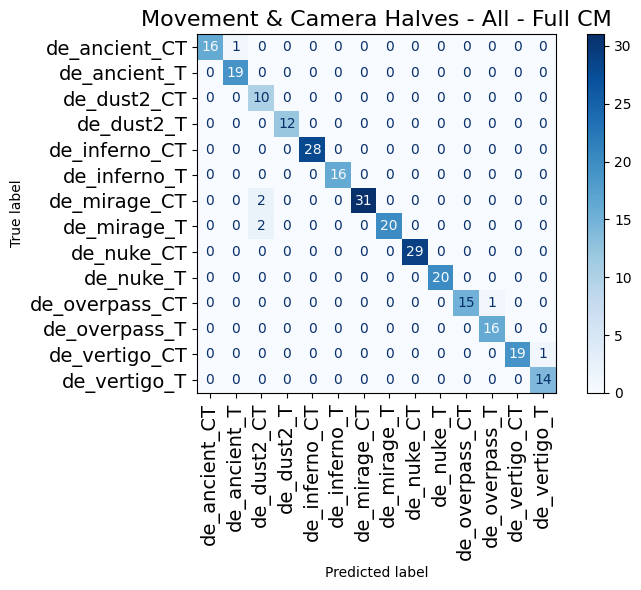

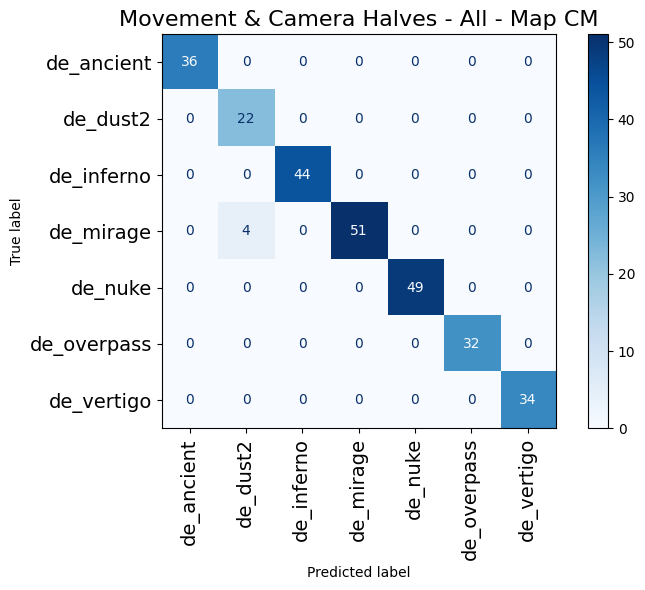

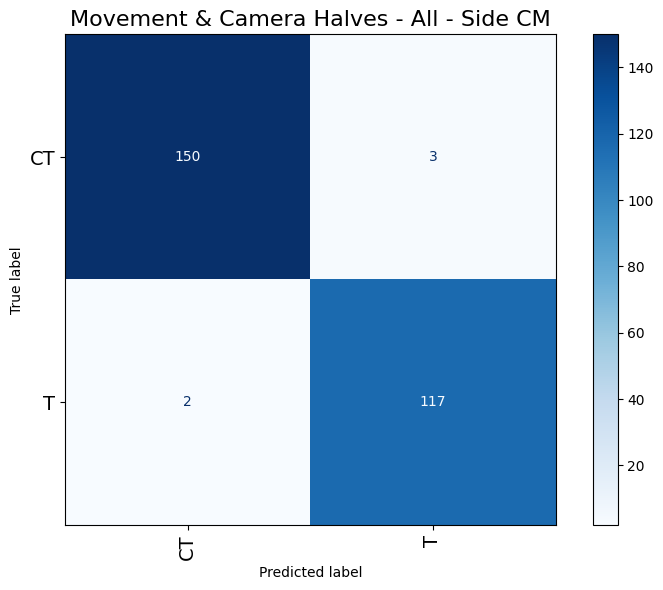

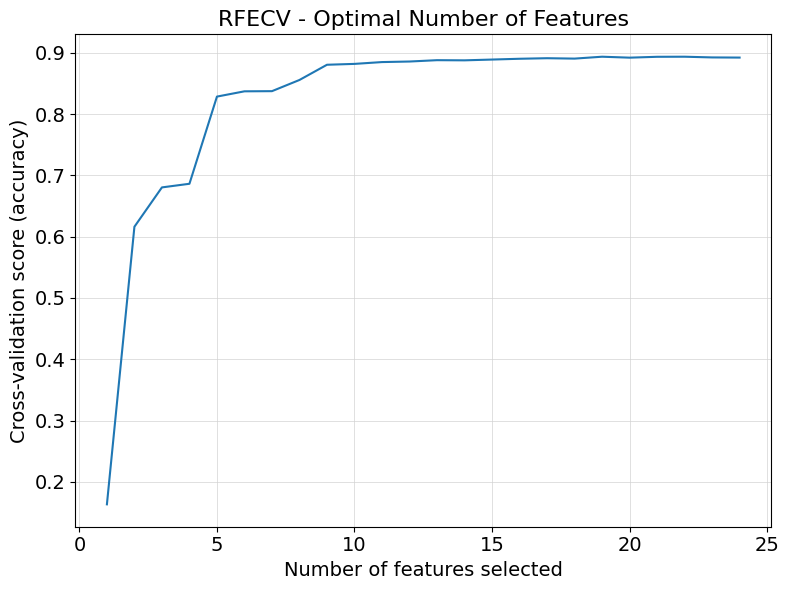


=== Movement & Camera Rounds - Feature Set: All ===
Feature count: 24


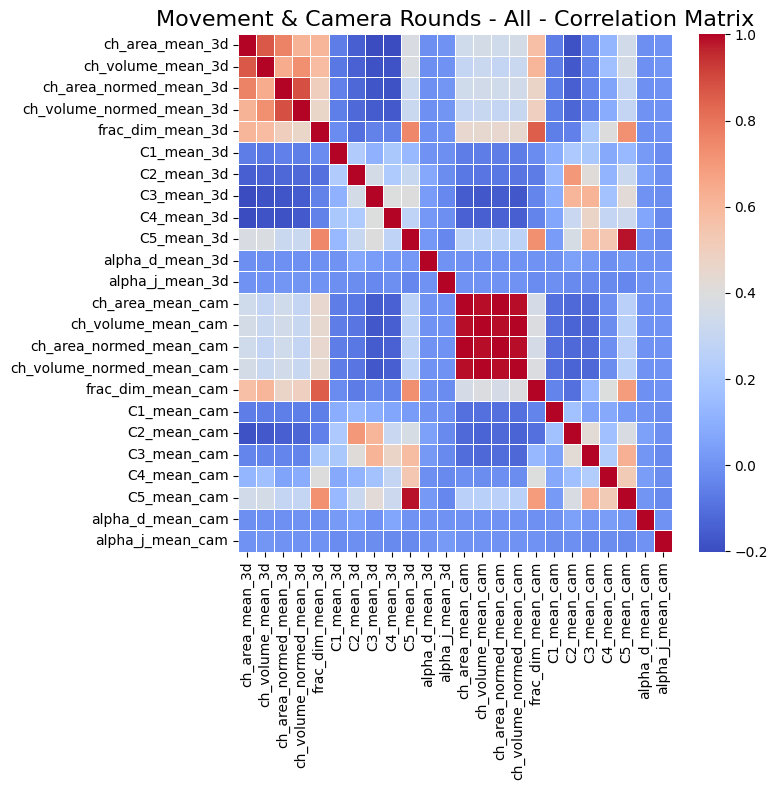

Train Accuracy: 0.9048
Test Accuracy: 0.8791 | Precision: 0.8827 | Recall: 0.8791 | F1: 0.8799


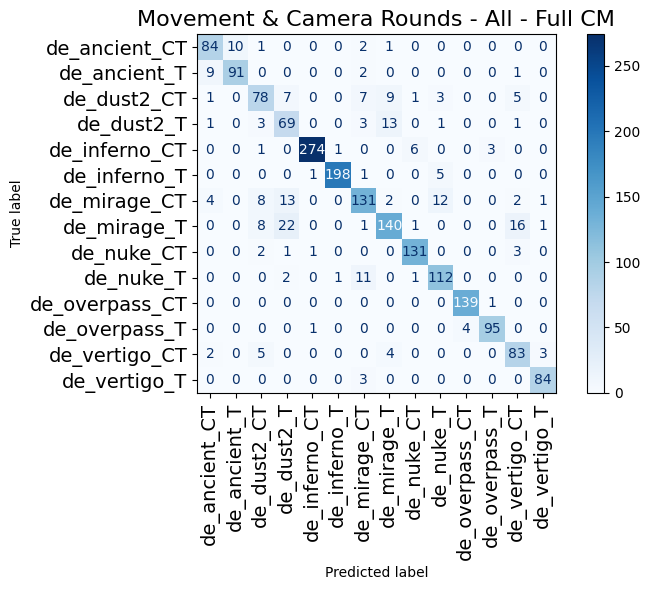

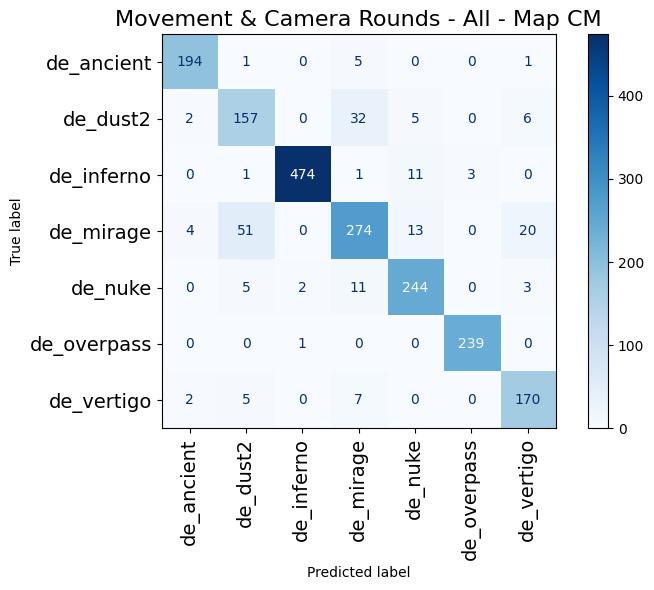

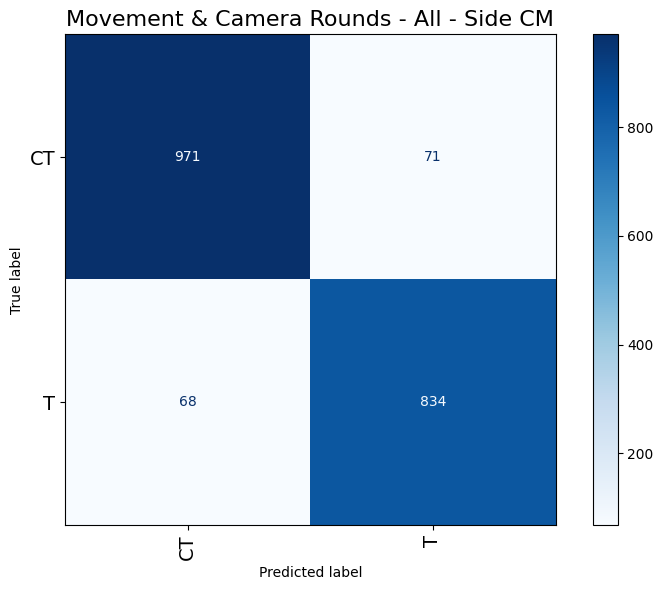


=== LaTeX Table ===
\begin{tabular}{llrrrrrr}
\toprule
Dataset & Feature Set & Num Features & Train Acc & Test Acc & Precision & Recall & F1 \\
\midrule
Camera Rounds & All & 12 & 0.4192 & 0.4257 & 0.4410 & 0.4257 & 0.4214 \\
Movement Rounds & All & 12 & 0.7420 & 0.7393 & 0.7460 & 0.7393 & 0.7394 \\
Camera Halves & All & 12 & 0.7668 & 0.6875 & 0.6938 & 0.6875 & 0.6837 \\
Movement Halves & All & 12 & 0.9558 & 0.9338 & 0.9343 & 0.9338 & 0.9337 \\
Movement & Camera Halves & All & 24 & 0.9935 & 0.9743 & 0.9791 & 0.9743 & 0.9752 \\
Movement & Camera Rounds & All & 24 & 0.9048 & 0.8791 & 0.8827 & 0.8791 & 0.8799 \\
\bottomrule
\end{tabular}



In [9]:
# === Configuration ===
save_figures = True
output_dir = "output_results"
os.makedirs(output_dir, exist_ok=True)

plt.style.use('default')  # Reset to clean style
plt.rcParams.update({
    'axes.facecolor': 'white',    # White plot background
    'figure.facecolor': 'white',  # White figure background
    'grid.color': 'lightgray',    # Light gray grid lines
    'grid.linestyle': '-',        # Solid grid lines
    'grid.linewidth': 0.5,        # Thin grid lines
})

# Font size settings
font_sizes = {
    "title": 16,
    "label": 14,
    "ticks": 14,
    "legend": 14
}

# === Helpers ===
def show_and_save(fig, filename):
    plt.tight_layout()
    if save_figures:
        fig.savefig(os.path.join(output_dir, filename), dpi=300)
    plt.show()
    plt.close(fig)

def show_and_save_conf_matrix(cm, labels, title, filename):
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(include_values=True, cmap='Blues', ax=ax, xticks_rotation='vertical')
    ax.set_title(title, fontsize=font_sizes["title"])
    ax.tick_params(axis='x', labelsize=font_sizes["ticks"])
    ax.tick_params(axis='y', labelsize=font_sizes["ticks"])
    show_and_save(fig, filename)

# === Store Results ===
results = []

# === Storage for bar-plot coefficients ===
barplot_coeffs_list = []

# === Dataset mapping for bar plots ===
model_map = {
    'Camera Rounds': 'CameraRounds',
    'Movement Rounds': 'PlayerRounds',
    'Camera Halves': 'CameraHalves',
    'Movement Halves': 'PlayerHalves',
    'Movement & Camera Rounds': 'BothRounds',
    'Movement & Camera Halves': 'BothHalves'
}

# === Main analysis loop ===
for df_name, df in dfs_dict.items():
    # Prepare all features
    all_features = feature_sets["All"]
    if df_name in ['Movement & Camera Halves', 'Movement & Camera Rounds']:
        all_features = [f + '_3d' for f in all_features] + [f + '_cam' for f in all_features]
    all_features = [f for f in all_features if '_mean' in f]

    X_all = df[all_features].to_numpy()
    le = LabelEncoder()
    y_all = le.fit_transform(df['Label'])

    # Train/test split
    X_train_rfecv, X_test_rfecv, y_train_rfecv, y_test_rfecv = train_test_split(
        X_all, y_all, test_size=0.2, random_state=42
    )
    scaler_rfecv = StandardScaler()
    X_train_rfecv = scaler_rfecv.fit_transform(X_train_rfecv)
    X_test_rfecv = scaler_rfecv.transform(X_test_rfecv)

    # RFECV
    rfecv = RFECV(
        estimator=LogisticRegression(max_iter=1000, class_weight='balanced', C=1, random_state=42),
        step=1,
        cv=StratifiedKFold(5, shuffle=True, random_state=42),
        scoring='accuracy'
    )
    rfecv.fit(X_train_rfecv, y_train_rfecv)

    # Feature importance
    importance_scores = np.zeros(len(all_features))
    selected_indices = np.where(rfecv.support_)[0]
    coefs = rfecv.estimator_.coef_
    mean_abs_coefs = np.mean(np.abs(coefs), axis=0)
    for idx, imp in zip(selected_indices, mean_abs_coefs):
        importance_scores[idx] = imp

    rfecv_ranking_df = pd.DataFrame({
        "Feature": all_features,
        "Ranking": rfecv.ranking_,
        "Importance": importance_scores
    }).sort_values(by="Importance", ascending=False)

    if save_figures:
        rfecv_ranking_df.to_csv(
            os.path.join(output_dir, f"{df_name}_RFECV_feature_ranking_importance.csv"),
            index=False
        )

    # RFECV plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
    ax.set_xlabel("Number of features selected", fontsize=font_sizes["label"])
    ax.set_ylabel("Cross-validation score (accuracy)", fontsize=font_sizes["label"])
    ax.set_title("RFECV - Optimal Number of Features", fontsize=font_sizes["title"])
    ax.tick_params(axis='x', labelsize=font_sizes["ticks"])
    ax.tick_params(axis='y', labelsize=font_sizes["ticks"])
    ax.grid(True, which='both', color='lightgray', linestyle='-', linewidth=0.5)
    show_and_save(fig, f"{df_name}_RFECV_plot.png")

    # === Loop through feature sets ===
    for name, feature_columns in feature_sets.items():
        if df_name in ['Movement & Camera Halves','Movement & Camera Rounds']:
            feature_columns = [sub + '_3d' for sub in feature_columns] + [sub + '_cam' for sub in feature_columns]

        feature_columns = [s for s in feature_columns if '_mean' in s]
        print(f"\n=== {df_name} - Feature Set: {name} ===")
        print(f"Feature count: {len(feature_columns)}")

        # === Correlation matrix ===
        correlation_matrix = df[feature_columns].corr()
        fig, ax = plt.subplots(figsize=(8, 8))
        sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5, ax=ax)
        ax.set_title(f'{df_name} - {name} - Correlation Matrix', fontsize=font_sizes["title"])
        show_and_save(fig, f"{df_name}_{name}_correlation_heatmap.png")

        # === Preprocess and train logistic regression ===
        X = df[feature_columns].to_numpy()
        le = LabelEncoder()
        y = le.fit_transform(df['Label'])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', C=1, random_state=42)
        log_reg.fit(X_train, y_train)
        y_pred = log_reg.predict(X_test)

        # === Metrics ===
        train_acc = log_reg.score(X_train, y_train)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        print(f"Train Accuracy: {train_acc:.4f}")
        print(f"Test Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

        results.append({
            "Dataset": df_name,
            "Feature Set": name,
            "Num Features": len(feature_columns),
            "Train Acc": train_acc,
            "Test Acc": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1": f1
        })

        # === Logistic regression coefficients ===
        coef_df = pd.DataFrame(log_reg.coef_, columns=feature_columns, index=le.classes_)
        avg_abs_coef = coef_df.abs().mean(axis=0)
        coef_ranking_df = avg_abs_coef.sort_values(ascending=False).reset_index()
        coef_ranking_df.columns = ['Feature', 'AvgAbsCoefficient']
        if save_figures:
            coef_ranking_df.to_csv(
                os.path.join(output_dir, f"{df_name}_{name}_LogReg_coef_importance.csv"),
                index=False
            )

        if name == "All":
            for feat, coef_val in avg_abs_coef.items():
                barplot_coeffs_list.append({
                    "Feature": feat,
                    "Coefficient": coef_val,
                    "Dataset": df_name,
                    "Model": model_map.get(df_name, "Other")
                })

        # === Confusion matrices ===
        labels = le.classes_
        cm = confusion_matrix(y_test, y_pred)
        show_and_save_conf_matrix(cm, labels, f'{df_name} - {name} - Full CM', f'{df_name}_{name}_conf_matrix_full.png')

        # Map-level CM
        y_map = y_test // 2
        y_pred_map = y_pred // 2
        map_names = [lab[:-3] for lab in labels[::2]]
        map_cm = confusion_matrix(y_map, y_pred_map)
        show_and_save_conf_matrix(map_cm, map_names, f'{df_name} - {name} - Map CM', f'{df_name}_{name}_conf_matrix_map.png')

        # Side-level CM
        y_side = y_test % 2
        y_pred_side = y_pred % 2
        side_cm = confusion_matrix(y_side, y_pred_side)
        show_and_save_conf_matrix(side_cm, ['CT', 'T'], f'{df_name} - {name} - Side CM', f'{df_name}_{name}_conf_matrix_side.png')

# === Save LaTeX table ===
results_df = pd.DataFrame(results)
latex_table = results_df.to_latex(index=False, float_format="%.4f")
if save_figures:
    with open(os.path.join(output_dir, "summary_metrics_table.txt"), 'w') as f:
        f.write(latex_table)
print("\n=== LaTeX Table ===")
print(latex_table)

# === Convert bar plot coefficients to DataFrame ===
barplot_coeffs_df = pd.DataFrame(barplot_coeffs_list)


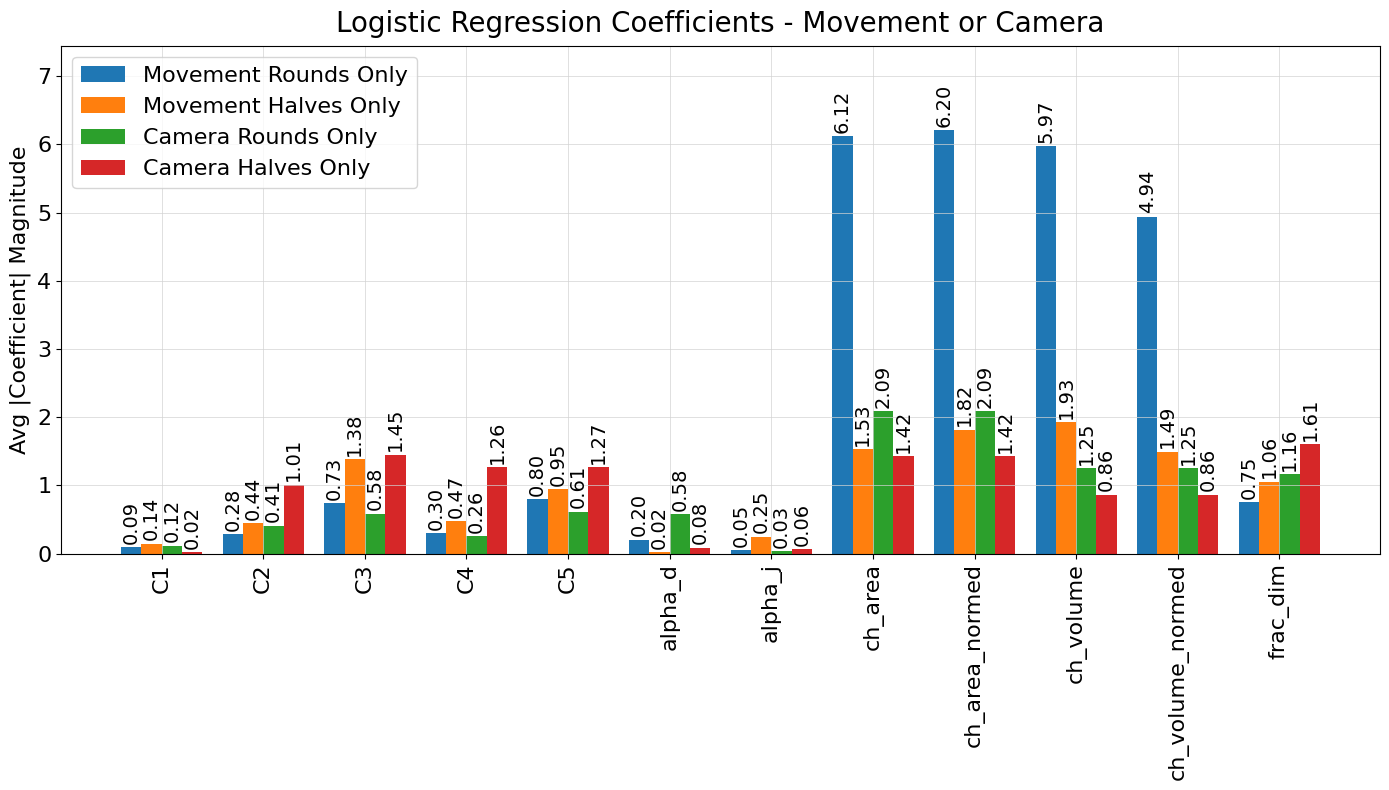

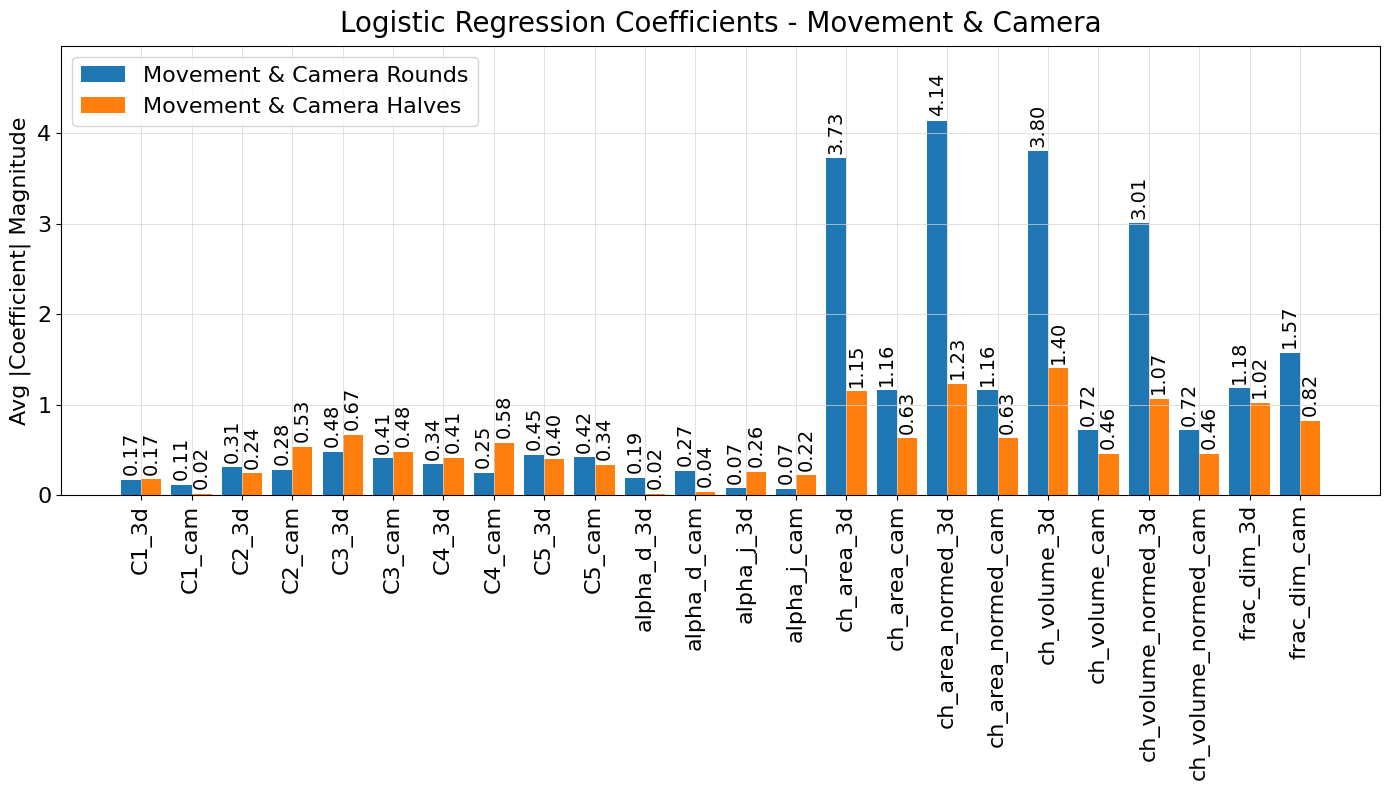

In [10]:
# Font size settings
font_sizes = {
    "title": 20,
    "label": 16,
    "ticks": 16,
    "legend": 16
}

# === Function to plot grouped bar plots with consistent styling ===
def plot_grouped_coefficients(df, models_to_include, title, filename, legend_names=None):
    df_plot = df[df['Model'].isin(models_to_include)]
    if df_plot.empty:
        print(f"Warning: No data to plot for '{title}'")
        return

    features = sorted(df_plot['Feature'].unique())
    x = np.arange(len(features))
    n_models = len(models_to_include)
    bar_width = 0.8 / n_models
    y_offset = 0.05  # spacing above bars for numbers

    # Larger figure for readability
    fig, ax = plt.subplots(figsize=(max(14, len(features)*0.5), 8))
    ax.set_facecolor('white')
    ax.grid(True, which='both', color='lightgray', linestyle='-', linewidth=0.5)

    max_val = 0
    for i, model in enumerate(models_to_include):
        vals = df_plot[df_plot['Model'] == model].set_index('Feature').reindex(features)['Coefficient'].fillna(0)
        max_val = max(max_val, vals.max())
        bars = ax.bar(x + i*bar_width, vals.values, width=bar_width,
                      label=legend_names[i] if legend_names else model)
        for bar, val in zip(bars, vals.values):
            ax.text(bar.get_x() + bar.get_width()/2, val + y_offset, f"{val:.2f}",
                    ha='center', va='bottom', fontsize=font_sizes["ticks"]-2, rotation=90)

    feature_labels = [f.replace('_mean', '') for f in features]
    ax.set_xticks(x + bar_width*(n_models-1)/2)
    ax.set_xticklabels(feature_labels, rotation=90, fontsize=font_sizes["ticks"])
    ax.set_ylabel("Avg |Coefficient| Magnitude", fontsize=font_sizes["label"])
    ax.set_ylim(0, max_val * 1.2)
    ax.set_title(title, pad=10, fontsize=font_sizes["title"])
    ax.legend(fontsize=font_sizes["legend"], loc='upper left')
    ax.tick_params(axis='y', labelsize=font_sizes["ticks"])
    ax.tick_params(axis='x', labelsize=font_sizes["ticks"])

    show_and_save(fig, filename)


# === Movement and Camera only  ===
plot_grouped_coefficients(
    barplot_coeffs_df,
    models_to_include=["PlayerRounds", "PlayerHalves","CameraRounds", "CameraHalves"],
    title="Logistic Regression Coefficients - Movement or Camera",
    filename="PlayerCamera_4models_barplot.png",
    legend_names=["Movement Rounds Only", "Movement Halves Only","Camera Rounds Only", "Camera Halves Only"]
)

# === Combined Movement + Camera (BothRounds & BothHalves) ===
plot_grouped_coefficients(
    barplot_coeffs_df,
    models_to_include=["BothRounds","BothHalves"],
    title="Logistic Regression Coefficients - Movement & Camera",
    filename="Combined_2models_barplot.png",
    legend_names=["Movement & Camera Rounds", "Movement & Camera Halves"]
)
